In [81]:
#This script performs several setps of time series analyis
# First section: Order selection for ARIMAX model based on lowest AIC and BIC
# Second section: Testing for model performance improvement

# The aim of our research is not to identify multicollinearity, endogeneity, the only purpose is to test in all the following scripts whether the predictive power of two different models can be improved.

import pandas as pd
import numpy as np
import pickle
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"

df['msci_lag1'] = df['msci'].shift(1)
df['sentiment_lag1'] = df['sentiment'].shift(1)
df['msci_lag2'] = df['msci'].shift(2)
df['sentiment_lag2'] = df['sentiment'].shift(2)
df['msci_lag3'] = df['msci'].shift(3)
df['sentiment_lag3'] = df['sentiment'].shift(3)

train = df[:'2020-01-01']
test = df['2020-01-02':]

In [82]:
#Model fitting
y = train['returns']
X_msci = train[["msci"]]
X_sent = train[["sentiment"]] #"sentiment" is our own sentiment score derived fromt the sentiment LDA
X_both = train[["msci","sentiment"]]#Both the MSCI and the sentiment score are included


ytest = test["returns"]

Xmsci_test = test[["msci"]]
Xsent_test = test[["sentiment"]]
Xboth_test = test[["msci", "sentiment"]]


def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))


def evaluateModel(data, exog, order, actual, exogtest):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    prediction = model_fit.get_forecast(steps=len(ytest), exog=exogtest).predicted_mean
    MAPE_f = mape(actual, prediction)
    RMSE_f = rmse(actual, prediction)
    return order, model_fit.aic, model_fit.bic, MAPE_f, RMSE_f

orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic, MAPE_base, RMSE_base = evaluateModel(y, None, order, ytest, None)
        results_base.append([order, aic, bic, MAPE_base, RMSE_base])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci, MAPE_msci, RMSE_msci = evaluateModel(y, X_msci, order, ytest, Xmsci_test)
        results_msci.append([order, aic_msci, bic_msci, MAPE_msci, RMSE_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent, MAPE_sent, RMSE_sent = evaluateModel(y, X_sent, order, ytest, Xsent_test)
        results_sent.append([order, aic_sent, bic_sent, MAPE_sent, RMSE_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both, MAPE_both, RMSE_both = evaluateModel(y, X_both, order, ytest, Xboth_test)
        results_both.append([order, aic_both, bic_both, MAPE_both, RMSE_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")


df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [83]:
print(df_sent)

     Order         AIC         BIC        MAPE      RMSE
0   (0, 1) -268.839117 -261.114984  102.571827  0.095555
1   (0, 2) -267.094798 -256.795954  102.556865  0.095322
2   (0, 3) -265.480033 -252.606478  101.369195  0.095554
3   (0, 4) -264.782629 -249.334363  101.414254  0.095643
4   (1, 0) -268.542234 -260.818101  102.034568  0.095683
5   (1, 1) -267.816631 -257.517787  101.302617  0.095369
6   (1, 2) -265.919038 -253.045484  101.627310  0.095444
7   (1, 3) -264.159331 -248.711065  100.995929  0.095710
8   (1, 4) -263.192539 -245.169562  101.369776  0.095703
9   (2, 0) -266.831401 -256.532557  102.740817  0.095414
10  (2, 1) -265.943179 -253.069624  101.668439  0.095475
11  (2, 2) -266.689390 -251.241124  125.760975  0.094749
12  (2, 3) -264.696849 -246.673872  125.933315  0.094728
13  (2, 4) -266.027795 -245.430107  114.345668  0.098075
14  (3, 0) -264.914385 -252.040830  102.124111  0.095500
15  (3, 1) -264.152196 -248.703930  100.546618  0.095729
16  (3, 2) -264.697324 -246.674

In [84]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 137.894
Date:                Sun, 21 Apr 2024   AIC                           -269.789
Time:                        13:34:11   BIC                           -262.065
Sample:                    01-01-2012   HQIC                          -266.666
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5220      0.341     -1.531      0.126      -1.190       0.146
ma.L1          0.6975      0.296      2.355      0.019       0.117       1.278
sigma2         0.0034      0.001      6.347      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 2.95
Prob(Q):                              0.71   Prob(JB):                         0.23
Heteroskedasticity (H):               1.19   Skew:                            -0.43
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,5.920186,0.821924


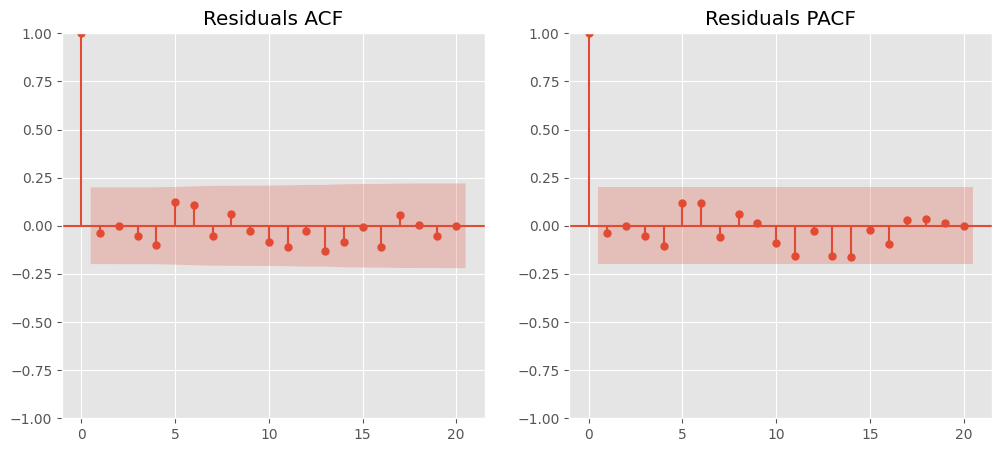

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


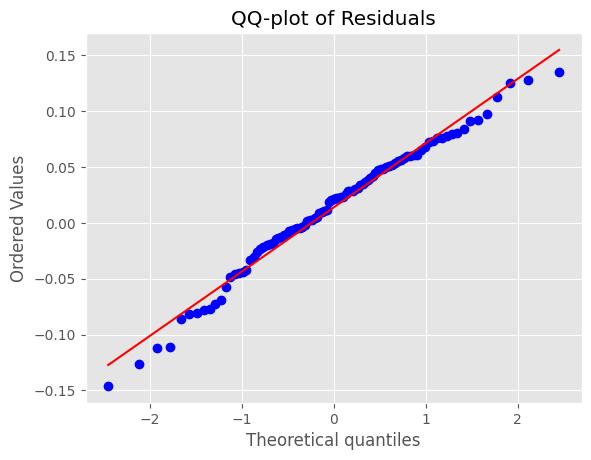

In [86]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [87]:
mscimodel = SARIMAX(y, X_msci, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 138.152
Date:                Sun, 21 Apr 2024   AIC                           -268.305
Time:                        13:34:11   BIC                           -258.006
Sample:                    01-01-2012   HQIC                          -264.140
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.0630      0.107      0.589      0.556      -0.147       0.273
ar.L1         -0.5212      0.331     -1.574      0.115      -1.170       0.128
ma.L1          0.7026      0.284      2.470      0.014       0.145       1.260
sigma2         0.0034      0.001      6.328      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 2.84
Prob(Q):                              0.68   Prob(JB):                         0.24
Heteroskedasticity (H):               1.20   Skew:                            -0.41
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,6.264692,0.792556


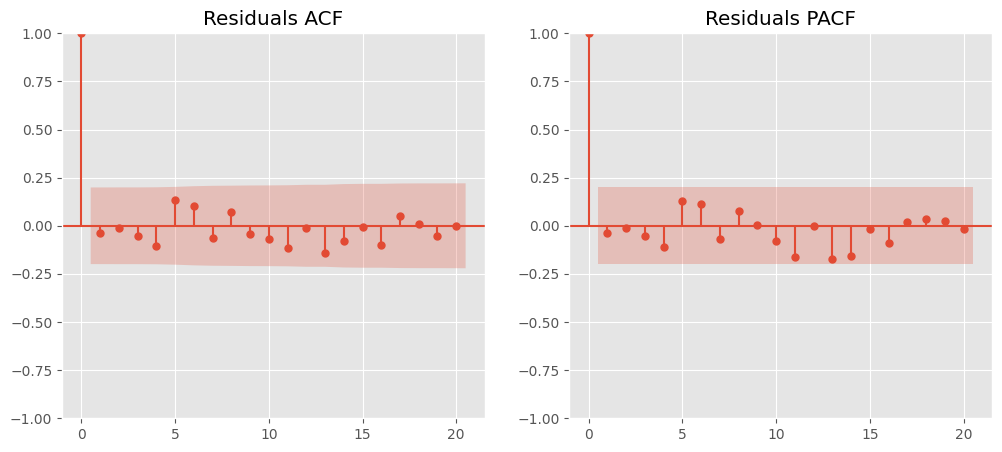

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


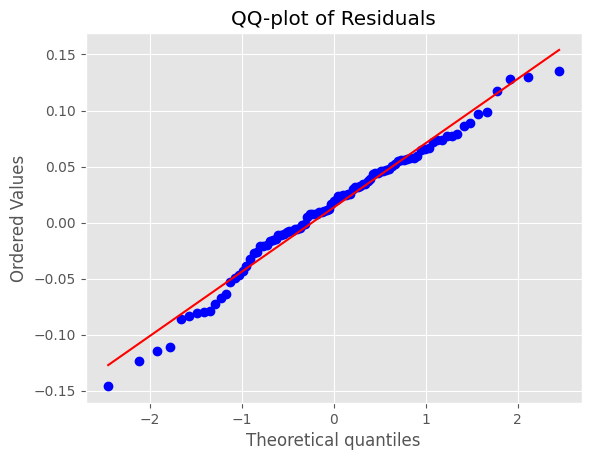

In [89]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [90]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 137.908
Date:                Sun, 21 Apr 2024   AIC                           -267.817
Time:                        13:34:12   BIC                           -257.518
Sample:                    01-01-2012   HQIC                          -263.652
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment     -0.0024      0.014     -0.171      0.864      -0.030       0.025
ar.L1         -0.5143      0.339     -1.516      0.130      -1.179       0.151
ma.L1          0.6928      0.295      2.346      0.019       0.114       1.272
sigma2         0.0034      0.001      6.349      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.72   Prob(JB):                         0.23
Heteroskedasticity (H):               1.19   Skew:                            -0.42
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,5.858746,0.826988


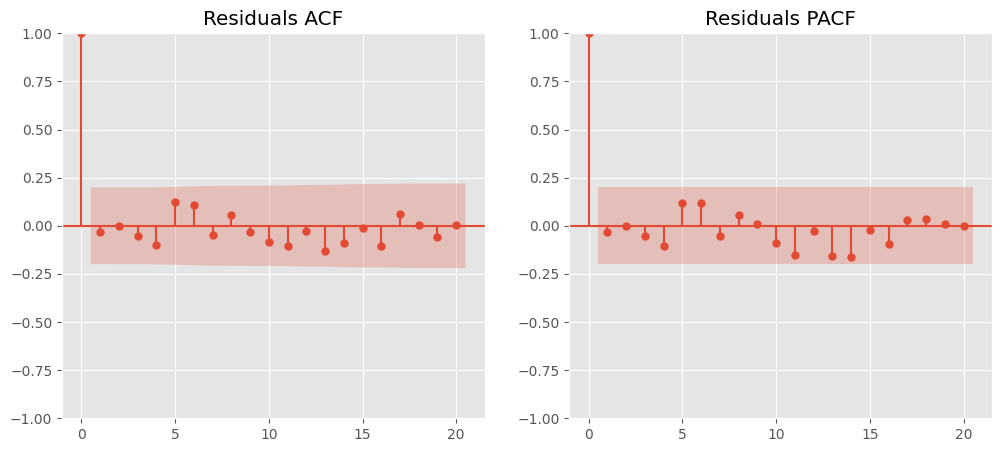

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


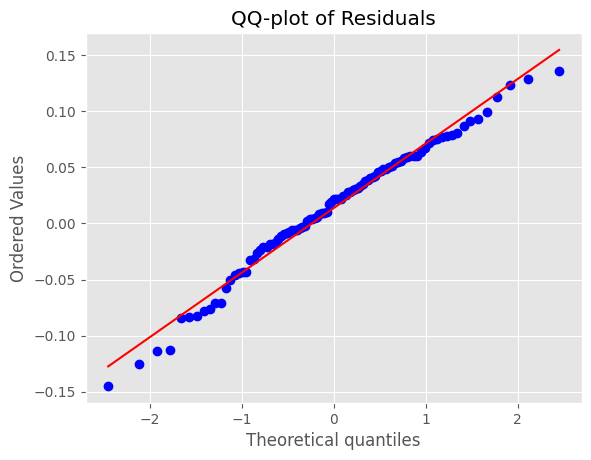

In [92]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [93]:
bothmodel = SARIMAX(y, X_both, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 138.182
Date:                Sun, 21 Apr 2024   AIC                           -266.364
Time:                        13:34:12   BIC                           -253.490
Sample:                    01-01-2012   HQIC                          -261.159
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.0652      0.108      0.605      0.545      -0.146       0.277
sentiment     -0.0035      0.014     -0.245      0.806      -0.032       0.025
ar.L1         -0.5118      0.327     -1.565      0.118      -1.153       0.129
ma.L1          0.6978      0.281      2.479      0.013       0.146       1.249
sigma2         0.0034      0.001      6.338      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.70   Prob(JB):                         0.25
Heteroskedasticity (H):               1.21   Skew:                            -0.41
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,6.197297,0.798424


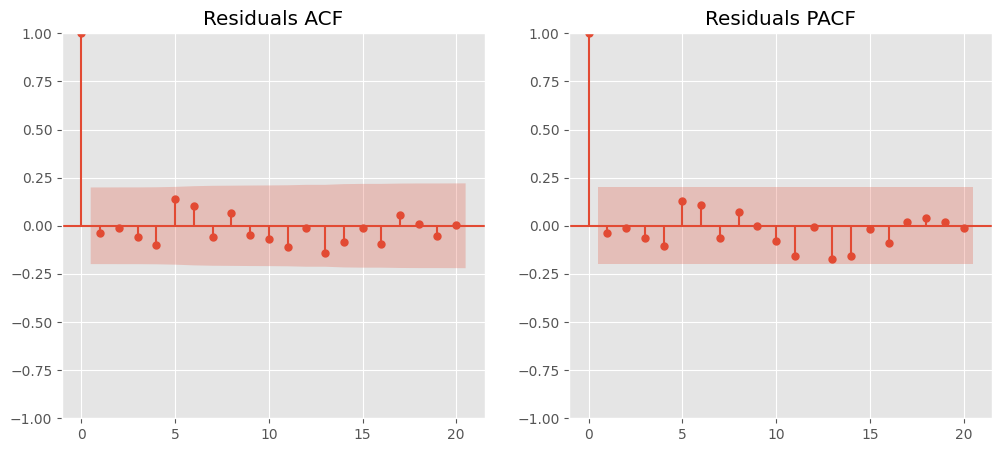

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


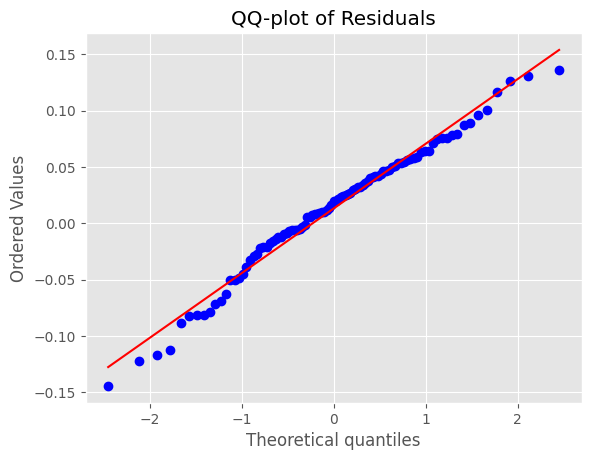

In [95]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [96]:
pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model        MAPE      RMSE
0       Base  100.007500  0.095459
1       MSCI  104.679499  0.096625
2  Sentiment  101.302617  0.095369
3       Both  109.179528  0.096542


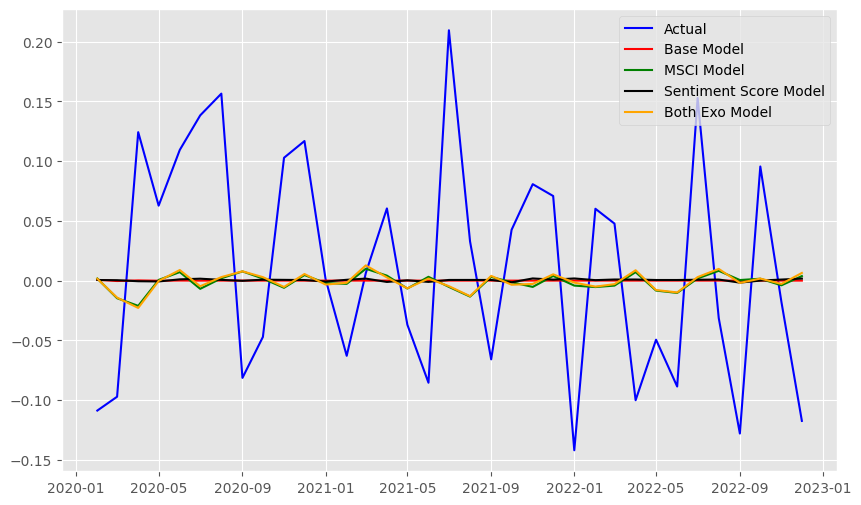

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='black')
plt.plot(test.index, pboth, label='Both Exo Model', color='orange')
plt.legend()

In [103]:
portfolio = pd.read_csv("./tsdata/portfolio.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"
log_returns = np.log(portfolio["0"] / portfolio["0"].shift(1)).dropna()


p_train = portfolio[:'2020-01-01']
p_test = portfolio['2020-01-02':]

predictions = pd.DataFrame()
predictions["Actual"] = log_returns['2020-01-02':].values
predictions["Base"]= pbase.values
predictions["Msci"]= pmsci.values
predictions["Sent"]= psent.values
predictions["Both"]= pboth.values

